<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being able to extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression or any other suitable classifier.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"
      

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings

**Changing the diplay options**

In [3]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
warnings.filterwarnings('ignore')

In [4]:
#Create the request
r = requests.get(URL)

In [5]:
soup = BeautifulSoup(r.text,'html.parser')

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [6]:
#Function to scrape the location
def extract_location_from_result(result):
    location = []
    for l in result.find_all('div', attrs={'class':'jobsearch-SerpJobCard'}):
        try:
            location.append(l.find(('div', 'span'), attrs={'class':'location'}).text)
        except:
            location.append(np.nan)
    return location

#Function to scrape the salary
def extract_salary_from_result(result):
    salary = []
    for s in result.find_all('div', attrs={'class':'jobsearch-SerpJobCard'}):
        try:
            salary.append(s.find(('div', 'span'), attrs={'class':'salary no-wrap'}).text.strip())
        except:
            salary.append(np.nan)
    return salary

#Function to scrape the job
def extract_job_from_result(result):
    job = []
    for j in result.find_all('div', attrs={'class':'jobsearch-SerpJobCard'}):
        try:
            job.append(j.find('a', attrs={'data-tn-element':'jobTitle'}).text.strip())
        except:
            job.append(np.nan)
    return job

#Function to scrape the company
def extract_company_from_result(result):
    company = []
    for c in result.find_all('div', attrs={'class':'jobsearch-SerpJobCard'}):
        try:
            company.append(c.find(('div', 'span'), attrs={'class':'company'}).text.strip())
        except:
            company.append(np.nan)
    return company

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [7]:
#YOUR_CITY = 'Seattle','Montgomery', 'San+Antonio', 'San+Diego', 'San+Jose', 'Jacksonville', 'Columbus', 'Fort+Worth', 'Indianapolis', 'Charlotte', 'Boston', 'Washington+DC', 'El+Paso', 'Detroit', 'Nashville', 'Memphis', 'Portland', 'Oklahoma+City', 'Las+Vegas'

**Webscraping data from more cities**

In [13]:
max_results_per_city = 1000 

results_location = []
results_job = []
results_salary = []
results_company = []

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY]):
    temp_location = []
    temp_job = []
    temp_salary = []
    temp_company = []
    
    for start in tqdm_notebook (range(0, max_results_per_city, 10)):
        url = 'http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}'.format(city,start)
        r = requests.get(url)
        global_soup = BeautifulSoup(r.text, 'html.parser')
        
        temp_company.append(extract_company_from_result(global_soup))
        temp_job.append(extract_job_from_result(global_soup))
        temp_salary.append(extract_salary_from_result(global_soup))
        temp_location.append(extract_location_from_result(global_soup))
        
    results_location.append(temp_location)
    results_job.append(temp_job)
    results_salary.append(temp_salary)
    results_company.append(temp_company)

   
        
        

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [324]:
df = pd.DataFrame({
    'Job': [item for l in results_job for sublist in l for item in sublist], 
    'Company': [item for l in results_company for sublist in l for item in sublist], 
    'Salary': [item for l in results_salary for sublist in l for item in sublist], 
    'Location':[item for l in results_location for sublist in l for item in sublist]
})

In [325]:
df.head()

,Job,Company,Salary,Location
0,Data Scientist,Downtown Music Publishing,NaN,"New York, NY"
1,Data Scientist,DISH Network,NaN,"New York, NY 10007 (Financial District area)"
2,Master Data Scientist,Deloitte,NaN,"New York, NY 10112 (Midtown area)"
3,"Data Scientist, Munich Engine",Munich Re America,NaN,"New York, NY"
4,Data Scientist,Butterfly Network,NaN,"New York, NY"


In [326]:
df.shape

(14952, 4)

In [327]:
duplicateRowsDF = df[df.duplicated()]

In [328]:
df.isnull().sum()[df.isnull().sum()!=0]
    
    

Company        7
Salary     13424
dtype: int64

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [329]:
df1 = df.drop_duplicates()

In [330]:
df2 = df1.dropna()

**Keeping only the year Salary and transforming them in number** 

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [337]:
df3 = df2[df2.Salary.str.contains('year')] 

In [338]:
from string import digits
nc = digits + '-' + ','

In [199]:
df3.Salary = df3.Salary.apply(lambda x : ''.join(c for c in x if c in nc))

In [ ]:
df3.Salary = df3.Salary.str.replace(',','').str.replace('+','').str.split('-', expand=True).astype(float).mean(axis=1)


In [347]:
df3.Salary.describe()

count       563.000000
mean     109016.337478
std       31077.351912
min       26832.000000
25%       89424.500000
50%      114000.000000
75%      130000.000000
max      187500.000000
Name: Salary, dtype: float64

### Save your results as a CSV

In [8]:
df3.to_csv('Data_Science.csv', sep='\t', index = False)


In [9]:
df3.shape

(563, 4)

In [8]:
df3 = pd.read_csv('Data_Science.csv', sep='\t')

In [9]:
df3.head()

,Job,Company,Salary,Location
0,"Data Analyst, PNA",New York City NYC HOUSING AUTHORITY,89349.0,"Manhattan, NY"
1,RESEARCH SCIENTIST,New York City HRA/DEPT OF SOCIAL SERVICES,78803.0,"Manhattan, NY"
2,Policy and Data Analyst,New York City DEPT OF HEALTH/MENTAL HYGIENE,65385.5,"Manhattan, NY"
3,Program Officer,New York City ADMIN FOR CHILDREN'S SVCS,79796.5,"Manhattan, NY"
4,Distinguished Data Scientist,Verizon,155500.0,"New York, NY 10007 (Financial District area)"


## QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your model's performance.

#### Load in the the data of scraped salaries

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

**Create a new column with a Binary value for the Salary**

In [10]:

df3['Binary_Salary'] = df3.Salary.apply(lambda x : 1 if x > df3.Salary.median() else 0)

#### Thought experiment: What is the baseline accuracy for this model?

In [11]:
#My median
df3.Salary.median()


114000.0

In [12]:
#Checking my baseline
df3.Binary_Salary.value_counts(normalize=True)

0    0.500888
1    0.499112
Name: Binary_Salary, dtype: float64

In [13]:
df3.head()

,Job,Company,Salary,Location,Binary_Salary
0,"Data Analyst, PNA",New York City NYC HOUSING AUTHORITY,89349.0,"Manhattan, NY",0
1,RESEARCH SCIENTIST,New York City HRA/DEPT OF SOCIAL SERVICES,78803.0,"Manhattan, NY",0
2,Policy and Data Analyst,New York City DEPT OF HEALTH/MENTAL HYGIENE,65385.5,"Manhattan, NY",0
3,Program Officer,New York City ADMIN FOR CHILDREN'S SVCS,79796.5,"Manhattan, NY",0
4,Distinguished Data Scientist,Verizon,155500.0,"New York, NY 10007 (Financial District area)",1


### Create a classification model to predict High/Low salary. 


#### Model based on location:

- Start by ONLY using the location as a feature. 
- Use logistic regression with both statsmodels and sklearn.
- Use a further classifier you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.

#### Model taking into account job levels and categories:

- Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title or whether 'Manager' is in the title. 
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value? 
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models. 
- Discuss model coefficients or feature importances as applicable.

#### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. 


- Use cross-validation to evaluate your models. 
- Evaluate the accuracy, AUC, precision and recall of the models. 
- Plot the ROC and precision-recall curves for at least one of your models.

## Simple Logistic Regression

**Cleaning the Location:** 
- Column for the State 
- Column for the city

In [14]:
df3['State'] = df3.Location.apply(lambda x : [i for i in x.split() if i.isupper()][0])

In [15]:
df3['City'] = df3.Location.apply(lambda x : x.split(',')[0])

In [16]:
df3.head()

,Job,Company,Salary,Location,Binary_Salary,State,City
0,"Data Analyst, PNA",New York City NYC HOUSING AUTHORITY,89349.0,"Manhattan, NY",0,NY,Manhattan
1,RESEARCH SCIENTIST,New York City HRA/DEPT OF SOCIAL SERVICES,78803.0,"Manhattan, NY",0,NY,Manhattan
2,Policy and Data Analyst,New York City DEPT OF HEALTH/MENTAL HYGIENE,65385.5,"Manhattan, NY",0,NY,Manhattan
3,Program Officer,New York City ADMIN FOR CHILDREN'S SVCS,79796.5,"Manhattan, NY",0,NY,Manhattan
4,Distinguished Data Scientist,Verizon,155500.0,"New York, NY 10007 (Financial District area)",1,NY,New York


**Choosing my predictor:**
- X based on the Location : State, City

**Choosing my target:**
- The Binary Salary

**Create Dummy variable**

In [17]:
#Chosing my predictors

y_log = df3.Binary_Salary
X_log = df3[['State','City']]
X_log_dummy = pd.get_dummies(X_log, drop_first=True)

In [18]:
#Train/Split
X_tr, X_ts, y_tr, y_ts = train_test_split(X_log_dummy, y_log,
                                                    stratify=y_log, test_size=0.3, random_state=1)


**Modelling with Scikit-learn**

In [19]:
model_log = LogisticRegression(solver='liblinear', multi_class='ovr')

In [20]:
model_log.fit(X_tr, y_tr)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [21]:
model_log.score(X_tr,y_tr)

0.7106598984771574

In [22]:
model_log.score(X_ts, y_ts)

0.7159763313609467

**Modelling with statsmodels**

In [23]:
import statsmodels.discrete.discrete_model as sm
#import statsmodels.api as sm

X_stats =  X_log_dummy.copy()
X_stats['intercept']=1


In [24]:
logit = sm.Logit(y_log, X_log_dummy).fit(method='lbfgs', maxiter=1000)
logit.summary()

/Users/macbethsecond/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Binary_Salary   No. Observations:                  563
Model:                          Logit   Df Residuals:                      473
Method:                           MLE   Df Model:                           89
Date:                Wed, 13 May 2020   Pseudo R-squ.:                  0.2992
Time:                        10:18:13   Log-Likelihood:                -273.47
converged:                       True   LL-Null:                       -390.24
Covariance Type:            nonrobust   LLR p-value:                 6.489e-15
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
State_AZ                        5.3054        nan        nan        nan         nan         nan
State_CA                        4.2075        nan        nan        nan         nan         nan
State_CO                        0.7131        nan        nan        nan         nan         nan
State_DE                             0        nan        nan        nan         nan         nan
State_FL                      -12.7003        nan        nan        nan         nan         nan
State_GA                       -9.3204        nan        nan        nan         nan         nan
State_IL                       -4.2269        nan        nan        nan         nan         nan
State_NJ                       -8.1581        nan        nan        nan         nan         nan
State_NY                      -17.8684        nan        nan        nan         nan         nan
State_OR                       -4.6538        nan        nan        nan         nan         nan
State_PA                       -1.9953        nan        nan        nan         nan         nan
State_TX                        3.9775        nan        nan        nan         nan         nan
State_WA                       -4.1344        nan        nan        nan         nan         nan
City_Atlanta                    9.3202        nan        nan        nan         nan         nan
City_Aurora                    -2.3232        nan        nan        nan         nan         nan
City_Austin                    -3.9204        nan        nan        nan         nan         nan
City_Bellevue                   5.0499        nan        nan        nan         nan         nan
City_Belmont                    8.6763        nan        nan        nan         nan         nan
City_Berkeley                  -4.2056        nan        nan        nan         nan         nan
City_Boulder                   -2.1788        nan        nan        nan         nan         nan
City_Brea                     -16.9694        nan        nan        nan         nan         nan
City_Bronx                     -5.2626        nan        nan        nan         nan         nan
City_Brooklyn                  17.8672        nan        nan        nan         nan         nan
City_Broomfield                20.8438        nan        nan        nan         nan         nan
City_Buckley AFB              -12.6541        nan        nan        nan         nan         nan
City_Burbank                    8.6763        nan        nan        nan         nan         nan
City_Burr Ridge                 4.2251        nan        nan        nan         nan         nan
City_Canastota                 -2.9064        nan        nan        nan         nan         nan
City_Centennial                -0.7107        nan        nan        nan         nan         nan
City_Chandler                  12.4004        nan        nan        nan         nan         nan
City_Chesterbrook             -10.5182        nan        nan        nan  

**Predictions**

In [25]:
predictions_train = model_log.predict(X_tr)
predictions_test = model_log.predict(X_ts)

**Confusion Matrix**

In [26]:
conf_mat = pd.DataFrame(confusion_matrix(y_ts, predictions_test), index = ['High', 'Low'], columns = ['Predicted High', 'Predicted Low'])


In [27]:
conf_mat

,Predicted High,Predicted Low
High,64,21
Low,27,57


**Report**

In [28]:
print(classification_report(y_ts,predictions_test))

              precision    recall  f1-score   support

           0       0.70      0.75      0.73        85
           1       0.73      0.68      0.70        84

    accuracy                           0.72       169
   macro avg       0.72      0.72      0.72       169
weighted avg       0.72      0.72      0.72       169



**Coefficient**

In [29]:
import matplotlib.pyplot as plt

In [30]:
Coefficient = pd.DataFrame(list(zip(X_ts.columns,model_log.coef_[0], np.abs(model_log.coef_[0]))), columns=['Var','Coef', 'Coef_abs']).sort_values(by='Coef_abs', ascending=False)


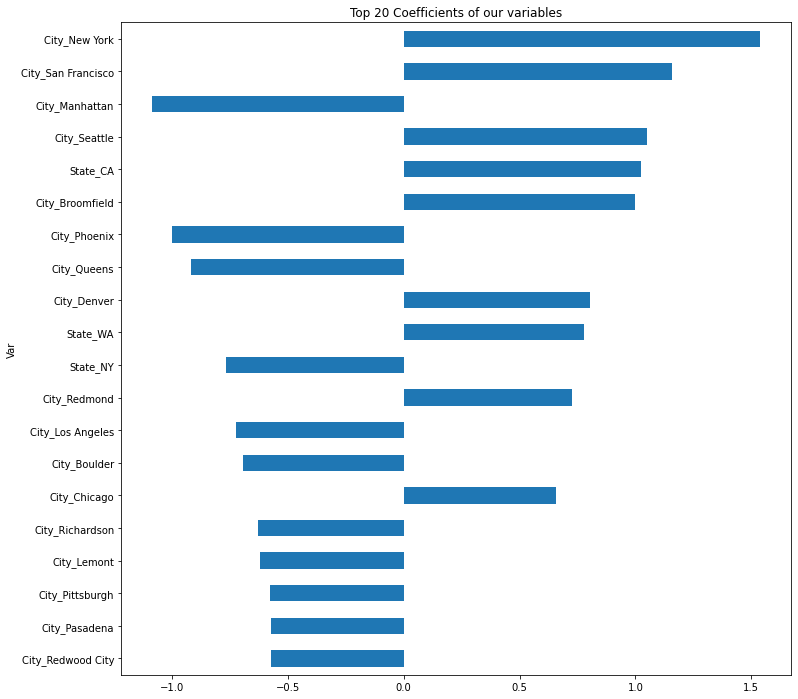

In [31]:
Coefficient.head(20).plot(kind='barh',x=0,y=1,figsize=(12,12),legend=False,title='Top 20 Coefficients of our variables', sort_columns=True)
plt.gca().invert_yaxis()


## Multiclass Logistic Regression

**Creating 4 class from my target:** 
- Very Low --- >  0
- Low --------- > 1
- High -------- >  2
- Very High -- > 3

In [32]:
q1 = df3.Salary.quantile(0.25)
q2 = df3.Salary.quantile()
q3 = df3.Salary.quantile(0.75)

In [33]:
df3['Class_Salary'] = pd.cut(df3.Salary,
                     bins=[0, q1, q2, q3, df3.Salary.max()],
                     labels=[0, 1, 2, 3])

**Checking my baseline**

In [34]:
df3.Class_Salary.value_counts(normalize=True)

2    0.257549
1    0.250444
0    0.250444
3    0.241563
Name: Class_Salary, dtype: float64

**Choosing my predictor:**
- X based on the Location : State, City

**Choosing my target:**
- The Class Salary

**Create Dummy variable**

In [35]:
y_ = df3.Class_Salary
X_ = df3[['State', 'City']]
X__dummy = pd.get_dummies(X_, drop_first=True)

In [36]:
#Train/test
X_train, X_test, y_train, y_test = train_test_split(X__dummy, y_,
                                                    stratify=y_, test_size=0.3, random_state=1)


**Modelling with Scikit-learn**

In [37]:
model_ = LogisticRegression(solver='liblinear', multi_class='ovr')

In [38]:
model_.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [39]:
model_.score(X_train,y_train)

0.5228426395939086

In [40]:
model_.score(X_test, y_test)

0.3727810650887574

**Coefficient**

In [41]:
model_.coef_[0]

array([-0.08472681, -0.83686155, -0.36749231,  0.47434758,  0.81445006,
        0.08095715,  0.37491797,  0.        ,  0.74410465, -0.34111425,
       -0.1875949 , -0.47478253, -0.79188315, -0.20855316,  0.20072591,
       -0.09173517,  0.22008725, -0.13914662, -0.13914662, -0.18276621,
        0.7229424 ,  0.03399603,  0.03399603, -0.19621994, -0.25037852,
       -0.13914662, -0.31328116, -0.3814493 , -0.3471108 ,  0.        ,
        0.        , -0.81216873, -0.22171065,  0.        ,  0.33567524,
       -0.22171065, -0.13914662,  0.01509358, -0.18195622, -0.66083762,
       -0.12615071, -0.13914662,  0.63963052, -0.14402083, -0.13914662,
        0.72241656, -0.19621994, -0.19987393, -0.22171065, -0.04631706,
       -0.32370769, -0.13914662,  0.49428132,  0.65950394,  0.82508636,
        0.86718623,  0.        , -0.22171065,  0.8638909 ,  0.49428132,
       -0.23719964,  0.40722503,  0.        , -0.77194695,  0.7229424 ,
        0.        ,  0.        ,  0.23725912, -0.89105687,  0.40

In [42]:
#(Very Low)
Coefficient_class_0 = pd.DataFrame(list(zip(X_test.columns,model_.coef_[0], np.abs(model_.coef_[0]))), columns=['Var','Coef', 'Coef_abs']).sort_values(by='Coef_abs', ascending=False)
Coefficient_class_1 = pd.DataFrame(list(zip(X_test.columns,model_.coef_[1], np.abs(model_.coef_[1]))), columns=['Var','Coef', 'Coef_abs']).sort_values(by='Coef_abs', ascending=False)
Coefficient_class_2 = pd.DataFrame(list(zip(X_test.columns,model_.coef_[2], np.abs(model_.coef_[2]))), columns=['Var','Coef', 'Coef_abs']).sort_values(by='Coef_abs', ascending=False)
Coefficient_class_3 = pd.DataFrame(list(zip(X_test.columns,model_.coef_[3], np.abs(model_.coef_[3]))), columns=['Var','Coef', 'Coef_abs']).sort_values(by='Coef_abs', ascending=False)


In [43]:
Coefficient_class_0.head()

,Var,Coef,Coef_abs
70,City_Pittsburgh,1.314293,1.314293
74,City_Queens,0.965618,0.965618
84,City_San Francisco,-0.948214,0.948214
68,City_Philadelphia,-0.891057,0.891057
55,City_Los Angeles,0.867186,0.867186


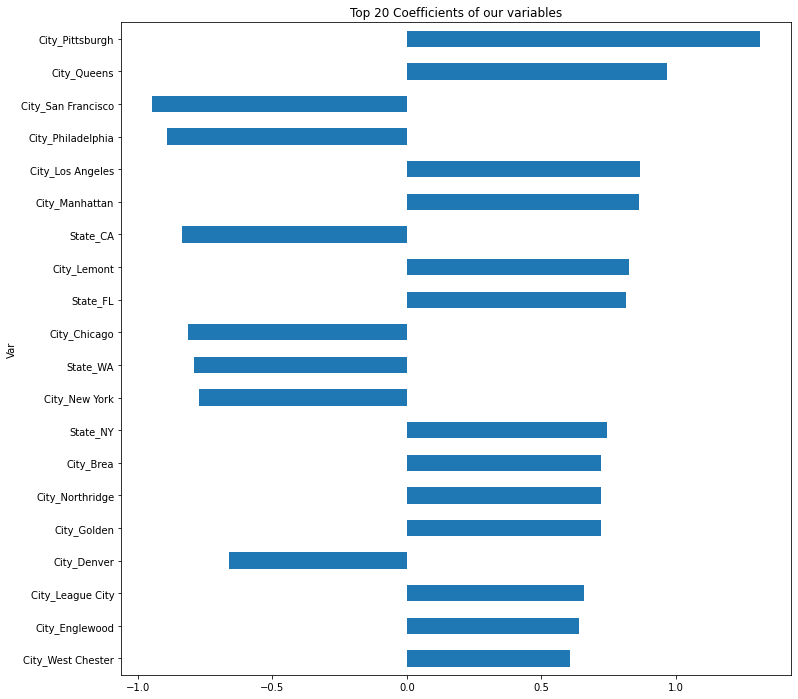

In [44]:
Coefficient_class_0.head(20).plot(kind='barh',x=0,y=1,figsize=(12,12),legend=False,title='Top 20 Coefficients of our variables', sort_columns=True)
plt.gca().invert_yaxis()

In [45]:
Coefficient_class_3.head()

,Var,Coef,Coef_abs
63,City_New York,1.412475,1.412475
1,State_CA,1.131561,1.131561
39,City_Denver,0.865768,0.865768
40,City_El Segundo,-0.849029,0.849029
70,City_Pittsburgh,-0.804529,0.804529


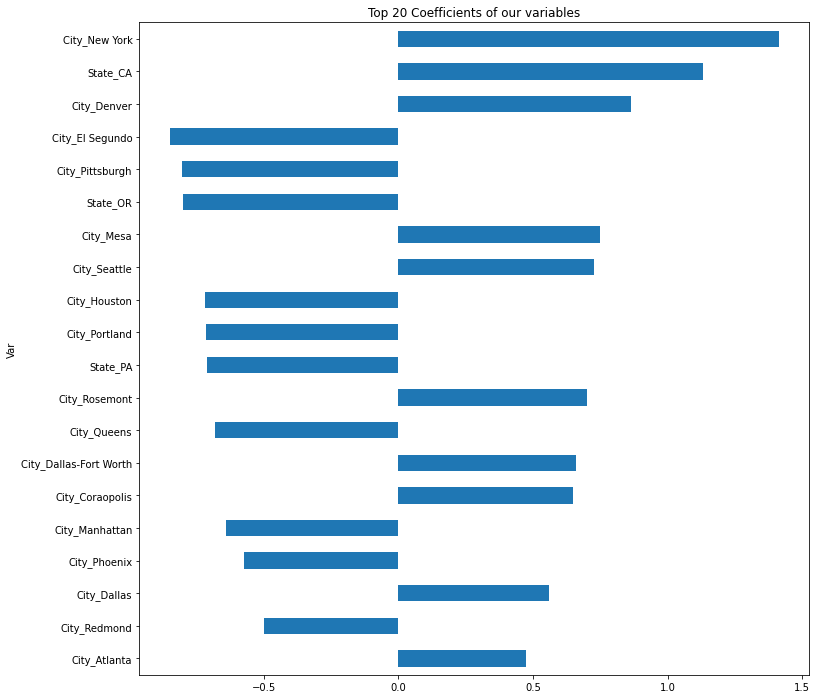

In [46]:
Coefficient_class_3.head(20).plot(kind='barh',x=0,y=1,figsize=(12,12),legend=False,title='Top 20 Coefficients of our variables', sort_columns=True)
plt.gca().invert_yaxis()

**Predictions**

In [47]:
pred_ = model_.predict(X_test)

**Confusion Matrix**

In [48]:
conf_ = pd.DataFrame(confusion_matrix(y_test, pred_), )

In [49]:
conf_

,0,1,2,3
0,14,13,5,10
1,7,11,11,13
2,1,12,13,18
3,1,5,10,25


**Report**

In [50]:
print(classification_report(y_test, pred_))

              precision    recall  f1-score   support

           0       0.61      0.33      0.43        42
           1       0.27      0.26      0.27        42
           2       0.33      0.30      0.31        44
           3       0.38      0.61      0.47        41

    accuracy                           0.37       169
   macro avg       0.40      0.38      0.37       169
weighted avg       0.40      0.37      0.37       169



**Trying other models using the previous Location variable**
- Keeping the same Train/Test split

**KNeighbors **
-Binary

In [51]:
kn_bin = KNeighborsClassifier()

In [52]:
kn_bin. fit(X_tr, y_tr)

KNeighborsClassifier()

In [53]:
kn_bin.score(X_tr,y_tr)

0.6928934010152284

In [54]:
kn_bin.score(X_ts, y_ts)

0.7218934911242604

In [55]:
kn_pred = kn_bin.predict(X_ts)

In [56]:
accuracy_score(y_ts, kn_pred)

0.7218934911242604

In [57]:
print (classification_report(y_ts, kn_pred))

              precision    recall  f1-score   support

           0       0.74      0.68      0.71        85
           1       0.70      0.76      0.73        84

    accuracy                           0.72       169
   macro avg       0.72      0.72      0.72       169
weighted avg       0.72      0.72      0.72       169



**KNeighbors **
-Binary

In [58]:
kn_clas = KNeighborsClassifier()

In [59]:
kn_clas.fit(X_train, y_train)

KNeighborsClassifier()

In [60]:
kn_clas.score(X_train, y_train)

0.4720812182741117

In [61]:
kn_clas.score(X_test, y_test)

0.378698224852071

In [62]:
kn_clas_pred = kn_clas.predict(X_test)

In [63]:
print(classification_report(y_test, kn_clas_pred))

              precision    recall  f1-score   support

           0       0.51      0.48      0.49        42
           1       0.24      0.29      0.26        42
           2       0.37      0.32      0.34        44
           3       0.43      0.44      0.43        41

    accuracy                           0.38       169
   macro avg       0.39      0.38      0.38       169
weighted avg       0.39      0.38      0.38       169



**Random Forest**

-Binary

In [64]:
rf_bin = RandomForestClassifier()

In [65]:
rf_bin.fit(X_tr, y_tr)

RandomForestClassifier()

In [66]:
rf_bin.score(X_tr, y_tr)

0.7309644670050761

In [67]:
rf_bin.score(X_ts, y_ts)

0.6863905325443787

In [68]:
rf_bin_prediction = rf_bin.predict(X_ts)

In [69]:
print(classification_report(y_ts, rf_bin_prediction))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69        85
           1       0.69      0.68      0.68        84

    accuracy                           0.69       169
   macro avg       0.69      0.69      0.69       169
weighted avg       0.69      0.69      0.69       169



**Random Forest**
- Class

In [70]:
rf_clas = RandomForestClassifier()

In [71]:
rf_clas.fit(X_train, y_train)

RandomForestClassifier()

In [72]:
rf_clas.score(X_train, y_train)

0.5406091370558376

In [73]:
rf_clas.score(X_test, y_test)

0.38461538461538464

In [74]:
rf_clas_prediction = rf_clas.predict(X_test)

In [75]:
print(classification_report(y_test, rf_clas_prediction))

              precision    recall  f1-score   support

           0       0.61      0.45      0.52        42
           1       0.25      0.21      0.23        42
           2       0.28      0.25      0.26        44
           3       0.42      0.63      0.50        41

    accuracy                           0.38       169
   macro avg       0.39      0.39      0.38       169
weighted avg       0.39      0.38      0.38       169



**Decision Tree**
- Binary

In [76]:
dt_bin = DecisionTreeClassifier()

In [77]:
dt_bin.fit(X_tr, y_tr)

DecisionTreeClassifier()

In [78]:
dt_bin.score(X_tr, y_tr)

0.7309644670050761

In [79]:
dt_bin.score(X_ts, y_ts)

0.7100591715976331

In [80]:
dt_bin_prediction = dt_bin.predict(X_ts)

In [81]:
print(classification_report(y_ts, dt_bin_prediction))

              precision    recall  f1-score   support

           0       0.69      0.76      0.73        85
           1       0.73      0.65      0.69        84

    accuracy                           0.71       169
   macro avg       0.71      0.71      0.71       169
weighted avg       0.71      0.71      0.71       169



**Decisiont Tree**

- Class

In [82]:
dt_clas = DecisionTreeClassifier()

In [83]:
dt_clas.fit(X_train, y_train)

DecisionTreeClassifier()

In [84]:
dt_clas.score(X_train, y_train)

0.5406091370558376

In [85]:
dt_clas.score(X_test, y_test)

0.378698224852071

In [86]:
dt_clas_prediction= dt_clas.predict(X_test)

In [87]:
print(classification_report(y_test, dt_clas_prediction))

              precision    recall  f1-score   support

           0       0.56      0.43      0.49        42
           1       0.24      0.21      0.23        42
           2       0.30      0.30      0.30        44
           3       0.42      0.59      0.49        41

    accuracy                           0.38       169
   macro avg       0.38      0.38      0.38       169
weighted avg       0.38      0.38      0.37       169



## Conclusion

Creating a Model using only Location.
From the data thet I have got from the web, after a deep cleaning of missing values and duplicates I deleted the address and I kept only the State and City which I stored in 2 different columns.

To run the models I transformed my 2 variables in dummy. I runned several models of Classifier we studied so far to compare them. As asked I started using a simple Logic Regression and I kept all this part of analysis very simple. I didn't tune deeply the models. 

I split my analysis in 2 main categories: 
- A Binary classification analysis
- A multiclass classification analysis

In the Binary I transformed the Salary data in 1 if my value was greater than my median value, and 0 for the rest. Using the median I end up with half of the values each, and so my baseline was 0.5
In the Multiclass I transformed the Salary data in 4 levels (0,1,2,3), chosing my boundaries using the percentiles. Each level ends up with the 25% of the values and my baseline was of course 0.25.

The hypotesis we are going to test is that we want to try to predict the salary using only the Location. I am expecting to see California and New York state (ad example) with a positive fairly strong value in the coefficients (As for my experience are 2 busy are of the States, more popular and more profitable.

**Binary**

For the Binary, all the models finished with very similar scores. The score is not low is not very high since our baseline was 0.5 
K-Neighbors Classifier gave me the best score, actually tiny bit better in the test than the score. All the train score and the test score were quite similar also in the other models. 
Logistic Regression was the second best model, then Decision Tree that with surprise had a better score than Random Forest (Honestly we are talking about a very small amount).
Since we canèt say anything about the features from the K Neighbors we can have a look at the coefficient of the Logistic Regression.

As expected New York and San Francisco have a positive coefficient for high Salary, but with surprise we find a in the third place a negative coefficient for Manhattan. This could be because Manhattan host only companies with a lower salary, or because is not the most popular area of New York to work in tech. 
We can coclude that these models are fairly decents to predict if the salary would be Low or High based on the location, also because they have a very similar score. Probably with more data we could increase the score.

**MultiClass**
I run the same models (Logistic Regression, KNeighbors Classifier, Decision Tree Classifier and Random Forest Classifier) for the 4 class as target. Our baseline was 0.25, and I end up with a very low score in all of them....still better than my baseline but so high to coclude positivly my research. Also in this case all the scores are similar: test score go from 0.37 to 0.35. Random Forest was the worst one and the other 3 finish with basically the same score. In this case we have a larger difference between the train score (average around 0.52-0.53) and the test score. I think was difficult recognize the Low from the High, and easier to recognize the very Low from the very High.
This kind of analysis needs to be tune on better parameter.
Plotting the coefficients from the Logistic Regression we can find some coherent results with our previous analysis on the Binary Salary, like New York and California State positie predictos for the class 3 and San francisco negative predictor for class 0. 
But we have found some surprise like Denver positive predictor of class 3, and we are not expecting Colorado be in this category. Could be that some outliers push the results in this direction.

## Model taking into account job levels and categories:
Create a few new variables in your dataframe to represent interesting features of a job title.

For example, create a feature that represents whether 'Senior' is in the title or whether 'Manager' is in the title.

Incorporate other text features from the title or summary that you believe will predict the salary.

Then build new classification models including also those features. Do they add any value?

Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.

Discuss model coefficients or feature importances as applicable.

## Creating new features from the Job Title

I am  going to start using a NLP method. All the words in the job title will finish as our predictors and they will be added to our previous location predictors.

In [88]:
df3.Job.head(10)

0                                    Data Analyst, PNA
1                                   RESEARCH SCIENTIST
2                              Policy and Data Analyst
3                                      Program Officer
4                         Distinguished Data Scientist
5                                       Data Scientist
6                                Data Scientist Senior
7                            Data Scientist, Analytics
8    Data Scientist - Cryptography and Internet Tec...
9                                       Data Scientist
Name: Job, dtype: object

**Using CountVectorizer Method and creating new features from each word in the Job Title**

In [89]:

cvec = CountVectorizer(stop_words='english')
cvec.fit(df3.Job)

cvec_mat = cvec.transform(df3.Job)

#Words present
words = cvec.get_feature_names()


In [90]:
# number of different words
print(len(words))

521


**Checking the most present words**

In [91]:
a = cvec_mat.sum(axis=0)
df_words = pd.DataFrame(a,columns=words).transpose().sort_values(by=0,ascending=False)

This is the count list of all the words we have in the Job title. I am going to use this list also later on.

In [92]:
df_words.head(10)

,0
data,246
scientist,189
engineer,172
software,99
senior,68
research,67
analyst,52
science,40
manager,32
systems,29


**Modelling with CountVectorizer and Multiclass Logistic Regression**

In [93]:
df4 = df3[['Job', 'State','City','Class_Salary','Binary_Salary' ]]

In [94]:
Vect=pd.DataFrame(cvec.transform(df3.Job).toarray(), index = df3['Job'].index, columns = words)#cvec.get_features_name())


**Choosing my predictor:**
- X based on the Location : State, City, Vect DataFrame with each words

**Choosing my target:**
- The Class Salary and Binary

**Create Dummy variable**

In [95]:
DF = pd.concat([df4[['State', 'City']], Vect], axis=1)

**My Predictors**

In [96]:
DF_dum = pd.get_dummies(DF, drop_first=True)

**My 2 target: Binary and Class**

In [97]:
target = df3.Class_Salary

In [98]:
target2 = df3.Binary_Salary

**Train/Test for Binary and Class**

In [99]:
#Class
X__tr, X__ts, tar__tr, tar__ts = train_test_split(DF_dum, target,stratify=target, test_size=0.3, random_state=1) 


In [100]:
#Binary
XB_tr, XB_ts, tar2_tr, tar2_ts = train_test_split(DF_dum, target2,stratify=target2, test_size=0.3, random_state=1) 


**Grid Search and Logistic Regression for Binary target**

In [101]:
modB = LogisticRegressionCV(solver='liblinear', 
                           multi_class='ovr', 
                           cv=5, 
                           max_iter=1000)

In [102]:
params = {'penalty': ['l1', 'l2'],
          'Cs': [np.logspace(-4, 4, 10)],
          'fit_intercept': [True, False],
          'solver': ['liblinear']}

gsB = GridSearchCV(estimator=modB,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  return_train_score=True)

In [103]:
gsB.fit(XB_tr,tar2_tr)

GridSearchCV(cv=5,
             estimator=LogisticRegressionCV(cv=5, max_iter=1000,
                                            multi_class='ovr',
                                            solver='liblinear'),
             param_grid={'Cs': [array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])],
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             return_train_score=True, scoring='accuracy')

In [104]:
print('Best Parameters:')
print(gsB.best_params_)
print()
print('Best estimator mean cross validated training score:')
print(gsB.best_score_)
print()
print('Best estimator score on the full training set:')
print(gsB.score(XB_tr, tar2_tr))
print()
print('Best estimator score on the test set:')
print(gsB.score(XB_ts, tar2_ts))

Best Parameters:
{'Cs': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]), 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}

Best estimator mean cross validated training score:
0.7995456020772476

Best estimator score on the full training set:
0.8730964467005076

Best estimator score on the test set:
0.7869822485207101


In [105]:
coeffigiendi = pd.DataFrame(list(zip(XB_ts.columns,gsB.best_estimator_.coef_[0], np.abs(gsB.best_estimator_.coef_[0]))), columns=['Var','Coef', 'Coef_abs']).sort_values(by='Coef_abs', ascending=False)
coeffigiendi.head()

,Var,Coef,Coef_abs
137,data,1.278627,1.278627
38,analyst,-1.139672,1.139672
400,research,-1.025190,1.025190
584,City_New York,0.768591,0.768591
453,sr,0.751833,0.751833


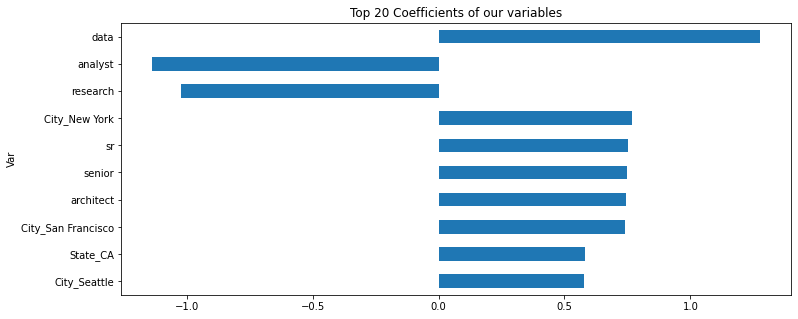

In [106]:
coeffigiendi.head(10).plot(kind='barh',x=0,y=1,figsize=(12,5),legend=False,title='Top 20 Coefficients of our variables', sort_columns=True)
plt.gca().invert_yaxis()


****Grid Search and Logistic Regression for Class target****

In [107]:
mod = LogisticRegressionCV(solver='liblinear', 
                           multi_class='ovr', 
                           cv=5, 
                           max_iter=1000)

In [108]:
params = {'penalty': ['l1', 'l2'],
          'Cs': [np.logspace(-4, 4, 10)],
          'fit_intercept': [True, False],
          'solver': ['liblinear']}

gs = GridSearchCV(estimator=mod,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  return_train_score=True)

In [109]:
gs.fit(X__tr,tar__tr)

GridSearchCV(cv=5,
             estimator=LogisticRegressionCV(cv=5, max_iter=1000,
                                            multi_class='ovr',
                                            solver='liblinear'),
             param_grid={'Cs': [array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])],
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             return_train_score=True, scoring='accuracy')

In [110]:
print('Best Parameters:')
print(gs.best_params_)
print()
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print()
print('Best estimator score on the full training set:')
print(gs.score(X__tr, tar__tr))
print()
print('Best estimator score on the test set:')
print(gs.score(X__ts, tar__ts))

Best Parameters:
{'Cs': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]), 'fit_intercept': False, 'penalty': 'l2', 'solver': 'liblinear'}

Best estimator mean cross validated training score:
0.5432651736449204

Best estimator score on the full training set:
0.868020304568528

Best estimator score on the test set:
0.47928994082840237


## Write conclusion

We had a sensible improvement for the Binary Target, that change from 0.71 to 0.78 and a pretty good improvement in the class from 0.37 to 0.5.
We considered the previous model good for the Binary target, we can consider it even better now. 
The model on the class target start to tell us something, and start to have a decent sensibility in the predictions. 
We can try to go deeper and not using all the words but choosing some keywords and trying to tune a better model.

## Creating new features from Job Title with criteria

In [111]:
df3.head()

,Job,Company,Salary,Location,Binary_Salary,State,City,Class_Salary
0,"Data Analyst, PNA",New York City NYC HOUSING AUTHORITY,89349.0,"Manhattan, NY",0,NY,Manhattan,0
1,RESEARCH SCIENTIST,New York City HRA/DEPT OF SOCIAL SERVICES,78803.0,"Manhattan, NY",0,NY,Manhattan,0
2,Policy and Data Analyst,New York City DEPT OF HEALTH/MENTAL HYGIENE,65385.5,"Manhattan, NY",0,NY,Manhattan,0
3,Program Officer,New York City ADMIN FOR CHILDREN'S SVCS,79796.5,"Manhattan, NY",0,NY,Manhattan,0
4,Distinguished Data Scientist,Verizon,155500.0,"New York, NY 10007 (Financial District area)",1,NY,New York,3


**Criteria for the choice:**
- Some of the key words are chosen from the list of most common words in Job Title
- Some of the key words are chosen personally from real experience
- Avoiding spelling mistake and similarity in the name thanks the function get_close_match which will put in the same category similar word (like analysis and analystic)



In [112]:
#List of words chosen as potential new features
lista_parole = ['engineer', 'software', 'senior', 'analyst', 'lead', 'director', 'junior', 'manager', 'architect', 'java', 'internal', 'internship', 'phd', 'research', 'sr', 'ai', 'data', 'scientist', 'machine', 'learning', 'developer', 'specialist', 'financial', 'security', 'marketing']


In [113]:
#Using this function to match similar words in the same column
from difflib import get_close_matches

In [114]:
#Creating new features from the list
for word in lista_parole:
    df3[word] = df3.Job.apply(lambda x : 1 if get_close_matches(word, x.lower().split(), cutoff = 0.6)  else 0)


In [115]:
df3.head()


,Job,Company,Salary,Location,Binary_Salary,State,City,Class_Salary,engineer,software,senior,analyst,lead,director,junior,manager,architect,java,internal,internship,phd,research,sr,ai,data,scientist,machine,learning,developer,specialist,financial,security,marketing
0,"Data Analyst, PNA",New York City NYC HOUSING AUTHORITY,89349.0,"Manhattan, NY",0,NY,Manhattan,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,RESEARCH SCIENTIST,New York City HRA/DEPT OF SOCIAL SERVICES,78803.0,"Manhattan, NY",0,NY,Manhattan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
2,Policy and Data Analyst,New York City DEPT OF HEALTH/MENTAL HYGIENE,65385.5,"Manhattan, NY",0,NY,Manhattan,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,Program Officer,New York City ADMIN FOR CHILDREN'S SVCS,79796.5,"Manhattan, NY",0,NY,Manhattan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Distinguished Data Scientist,Verizon,155500.0,"New York, NY 10007 (Financial District area)",1,NY,New York,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0


**Choosing my predictor:**
- X based on the Location : State, City, Key words

**Choosing my target:**
- The Binary Salary

**Create Dummy variable**

In [116]:
df_dummy = pd.concat([pd.get_dummies(df3[['State', 'City']], drop_first=True), df3.loc[:,'engineer':]], axis=1)


In [117]:
Xtr, Xts, ytr, yts = train_test_split(df_dummy, df3.Binary_Salary,stratify=df3.Binary_Salary, test_size=0.3, random_state=1) 


**Modelling with Linear Regression for the Binary Salary Target**

In [118]:
new_model = LogisticRegressionCV(solver='liblinear', 
                                 multi_class='ovr', 
                                 cv=5, 
                                 max_iter=1000)


In [119]:
params = {'penalty': ['l1', 'l2'],
          'Cs': [np.logspace(-4, 4, 10)],
          'fit_intercept': [True, False],
          'solver': ['liblinear']}

g_log = GridSearchCV(estimator=new_model,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  return_train_score=True)

In [120]:
g_log.fit(Xtr, ytr)

GridSearchCV(cv=5,
             estimator=LogisticRegressionCV(cv=5, max_iter=1000,
                                            multi_class='ovr',
                                            solver='liblinear'),
             param_grid={'Cs': [array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])],
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             return_train_score=True, scoring='accuracy')

In [121]:
print('Best Parameters:')
print(g_log.best_params_)
print()
print('Best estimator mean cross validated training score:')
print(g_log.best_score_)
print()
print('Best estimator score on the full training set:')
print(g_log.score(Xtr, ytr))
print()
print('Best estimator score on the test set:')
print(g_log.score(Xts, yts))

Best Parameters:
{'Cs': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]), 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}

Best estimator mean cross validated training score:
0.7918532943849399

Best estimator score on the full training set:
0.8629441624365483

Best estimator score on the test set:
0.7751479289940828


**Predictions**

In [122]:
y_hat = g_log.predict(Xts)

**Confusion Matrix**

In [123]:
confusion_matrix(yts, y_hat)

array([[64, 21],
       [17, 67]])

**Report**

In [124]:
print(classification_report(yts, y_hat))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77        85
           1       0.76      0.80      0.78        84

    accuracy                           0.78       169
   macro avg       0.78      0.78      0.78       169
weighted avg       0.78      0.78      0.78       169



**Choosing my predictor:**
- X based on the Location : State, City, Key words

**Choosing my target:**
- The Class Salary

**Using the same dummy variables from previous fit**

In [125]:
#Train/Test
Xtr_class, Xts_class, ytr_class, yts_class = train_test_split(df_dummy, df3.Class_Salary,stratify=df3.Class_Salary, test_size=0.3, random_state=1) 


**Modelling with Multiclass Linear Regression for Class Salary target**

In [126]:
new_model_class = LogisticRegressionCV(solver='liblinear', 
                                       multi_class='ovr', 
                                       cv=5, 
                                       max_iter=1000)


In [127]:
params = {'penalty': ['l1', 'l2'],
          'Cs': [np.logspace(-4, 4, 10)],
          'fit_intercept': [True, False],
          'solver': ['liblinear']}

g_class = GridSearchCV(estimator=new_model,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  return_train_score=True)

In [128]:
g_class.fit(Xtr_class, ytr_class)

GridSearchCV(cv=5,
             estimator=LogisticRegressionCV(cv=5, max_iter=1000,
                                            multi_class='ovr',
                                            solver='liblinear'),
             param_grid={'Cs': [array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])],
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             return_train_score=True, scoring='accuracy')

In [129]:
print('Best Parameters:')
print(g_class.best_params_)
print()
print('Best estimator Cs:')
print(g_class.best_estimator_.Cs)
print()
print('Best estimator mean cross validated training score:')
print(g_class.best_score_)
print()
print('Best estimator score on the full training set:')
print(g_class.score(Xtr_class, ytr_class))
print()
print('Best estimator score on the test set:')
print(g_class.score(Xts_class, yts_class))

Best Parameters:
{'Cs': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]), 'fit_intercept': False, 'penalty': 'l2', 'solver': 'liblinear'}

Best estimator Cs:
[1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]

Best estimator mean cross validated training score:
0.441544952937358

Best estimator score on the full training set:
0.4949238578680203

Best estimator score on the test set:
0.41420118343195267


##  Conclusion

## Trying GridSearch and Ensemble (Bagging) in combo for other models

I am going to go as far as my machine and my knowledge can, using a Bagging and a GridSearch in combo to tune as deep as possible.

## - Binary Salary

**Choosing my predictors for all the others models:**
- X based on the Location : State, City, Key words

**Choosing my target:**
- The Binary Salary

**Using the same dummy variables from previous fit**

**-Creating a train/test for the models to run outside of the main function** (See later)

In [130]:
from sklearn.ensemble import BaggingClassifier


In [131]:
#Train/Test
XTR_Binary, XTS_Binary, yTR_Binary, yTS_Binary = train_test_split(df_dummy, df3.Binary_Salary,stratify=df3.Binary_Salary, test_size=0.3, random_state=1) 


In [132]:
#Models

model_K = KNeighborsClassifier()

model_L = LogisticRegression()

model_RF = RandomForestClassifier()
    
model_DT = DecisionTreeClassifier()



**Creating a function to run the favorite model**
- Arguments: model, predictors (dummy locations and words), target (Could be Binary or Class)

- The function fit the model, the model will be used as base estimator in the Bagging Classifier, that will go in a grid search.
 
- The purpose is to check as more model possible and go as deep as my machine can to look for best parameters and samples

- Output: Test score, Train score, Prediction, Confusion Matrix, Classification Report, Model


In [133]:
from scipy import sparse

In [134]:
pred_matrix = sparse.csr_matrix(df_dummy)

In [135]:
def madness_begging(model, predictor, target):
    
    #pred_matrix = sparse.csr_matrix(predictor)

    X_train, X_test, y_train, y_test = train_test_split(pred_matrix, target, stratify=target, test_size=0.3, random_state=2)
    
    model.fit(X_train, y_train)
   
    model_Beg_Pardon = BaggingClassifier(base_estimator=model, n_estimators=100)
    params = {'max_samples': np.linspace(0.8, 1.0, 3),
          'max_features': range(int(3/4.*predictor.shape[1]), predictor.shape[1]+1)}

    grid = GridSearchCV(model_Beg_Pardon, param_grid=params, cv=5)
    
    grid.fit(X_train, y_train)
    
    simple_scores = cross_val_score(model, predictor, target, cv=10)
    test_simple_score = model.score(X_test, y_test)
    bagging_scores = cross_val_score(model_Beg_Pardon, predictor, target, cv=10)
    massive_score_train = grid.score(X_train, y_train)
    massive_score_test = grid.score(X_test, y_test)
    
    y_hat = grid.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_hat)
    class_report = classification_report(y_test, y_hat)
    
    
    print('Basic model chosen:')
    print(model)
    print()
    print('Cross val score on train score:')
    print(simple_scores)
    print(simple_scores.mean)
    print('Test score:')
    print(test_simple_score)
    print()
    print('Bagging')
    print(grid.best_params_)
    print()
    print('Cross val score on train score:')
    print(bagging_scores)
    print(bagging_scores.mean)
    print()
    print('Train score:')
    print(massive_score_train)
    print()
    print('Test score:')
    print(massive_score_test)
    print()
    print('Confusion Matrix')
    print(conf_matrix)
    print()
    print('Classification Report')
    print(class_report)
    
    return massive_score_test, massive_score_train, y_hat, conf_matrix, class_report, grid


**Running Logistic Regression lr Binary (Again)**

In [136]:
lr_test_score_Binary, lr_train_score_Binary, lr_predictions_Binary, lr_conf_matrix_Binary, lr_class_report_Binary, lr_Binary = madness_begging(model_L, pred_matrix, df3.Binary_Salary)


Basic model chosen:
LogisticRegression()

Cross val score on train score:
[0.64912281 0.73684211 0.64912281 0.69642857 0.66071429 0.53571429
 0.44642857 0.39285714 0.64285714 0.55357143]
<built-in method mean of numpy.ndarray object at 0x12c5d03a0>
Test score:
0.7751479289940828

Bagging
{'max_features': 106, 'max_samples': 1.0}

Cross val score on train score:
[0.64912281 0.73684211 0.63157895 0.67857143 0.67857143 0.57142857
 0.44642857 0.33928571 0.625      0.55357143]
<built-in method mean of numpy.ndarray object at 0x12c347b20>

Train score:
0.8426395939086294

Test score:
0.7692307692307693

Confusion Matrix
[[61 24]
 [15 69]]

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.72      0.76        85
           1       0.74      0.82      0.78        84

    accuracy                           0.77       169
   macro avg       0.77      0.77      0.77       169
weighted avg       0.77      0.77      0.77       169



In [137]:
lr_Binary = lr_Binary.best_estimator_.base_estimator_.fit(XTR_Binary,yTR_Binary)

In [138]:
Coefficient_lr_Binary = pd.DataFrame(list(zip(XTS_Binary.columns,lr_Binary.coef_[0], np.abs(lr_Binary.coef_[0]))), columns=['Var','Coef', 'Coef_abs']).sort_values(by='Coef_abs', ascending=False)


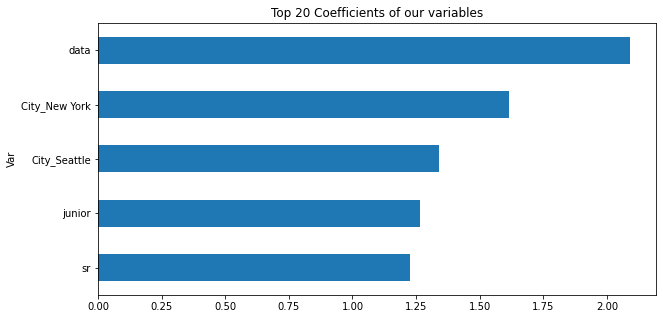

In [139]:
Coefficient_lr_Binary.head().plot(kind='barh', x=0,y=1,figsize=(10,5),legend=False,title='Top 20 Coefficients of our variables', sort_columns=True)
plt.gca().invert_yaxis()

**Running Decision Tree model  dtr_Binary**

In [140]:
dtr_test_score_Binary, dtr_train_score_Binary, dtr_predictions_Binary, dtr_conf_matrix_Binary, dtr_class_report_Binary, dtr_Binary = madness_begging(model_DT, pred_matrix, df3.Binary_Salary)


Basic model chosen:
DecisionTreeClassifier()

Cross val score on train score:
[0.70175439 0.64912281 0.49122807 0.66071429 0.69642857 0.26785714
 0.33928571 0.44642857 0.66071429 0.625     ]
<built-in method mean of numpy.ndarray object at 0x12ca11490>
Test score:
0.6686390532544378

Bagging
{'max_features': 107, 'max_samples': 0.8}

Cross val score on train score:
[0.85964912 0.63157895 0.42105263 0.60714286 0.73214286 0.33928571
 0.30357143 0.39285714 0.64285714 0.58928571]
<built-in method mean of numpy.ndarray object at 0x12c32d170>

Train score:
0.9593908629441624

Test score:
0.7455621301775148

Confusion Matrix
[[58 27]
 [16 68]]

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.68      0.73        85
           1       0.72      0.81      0.76        84

    accuracy                           0.75       169
   macro avg       0.75      0.75      0.74       169
weighted avg       0.75      0.75      0.74       169



In [141]:
dtr_Binary = dtr_Binary.best_estimator_.base_estimator_.fit(XTR_Binary, yTR_Binary)

In [142]:
fi_dtr_Binary = pd.DataFrame({
    'feature': XTR_Binary.columns,
    'importance': dtr_Binary.feature_importances_
})

fi_dtr_Binary.sort_values('importance', ascending=False, inplace=True)
fi_dtr_Binary.head()

,feature,importance
118,data,0.185909
103,software,0.073376
105,analyst,0.065972
110,architect,0.054469
108,junior,0.037005


In [155]:
from io import StringIO

In [156]:
#from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

In [159]:
def plot_dt(dt, feature_names=None):
    print('Max depth:', dt.max_depth)
    dot_data = StringIO()
    export_graphviz(dt,
                    out_file=dot_data,
                    max_depth = 5,
                    filled=True,
                    rounded=True,
                    special_characters=True,
                    feature_names=feature_names
                    )

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

**Plot of the Decision**

Max depth: None


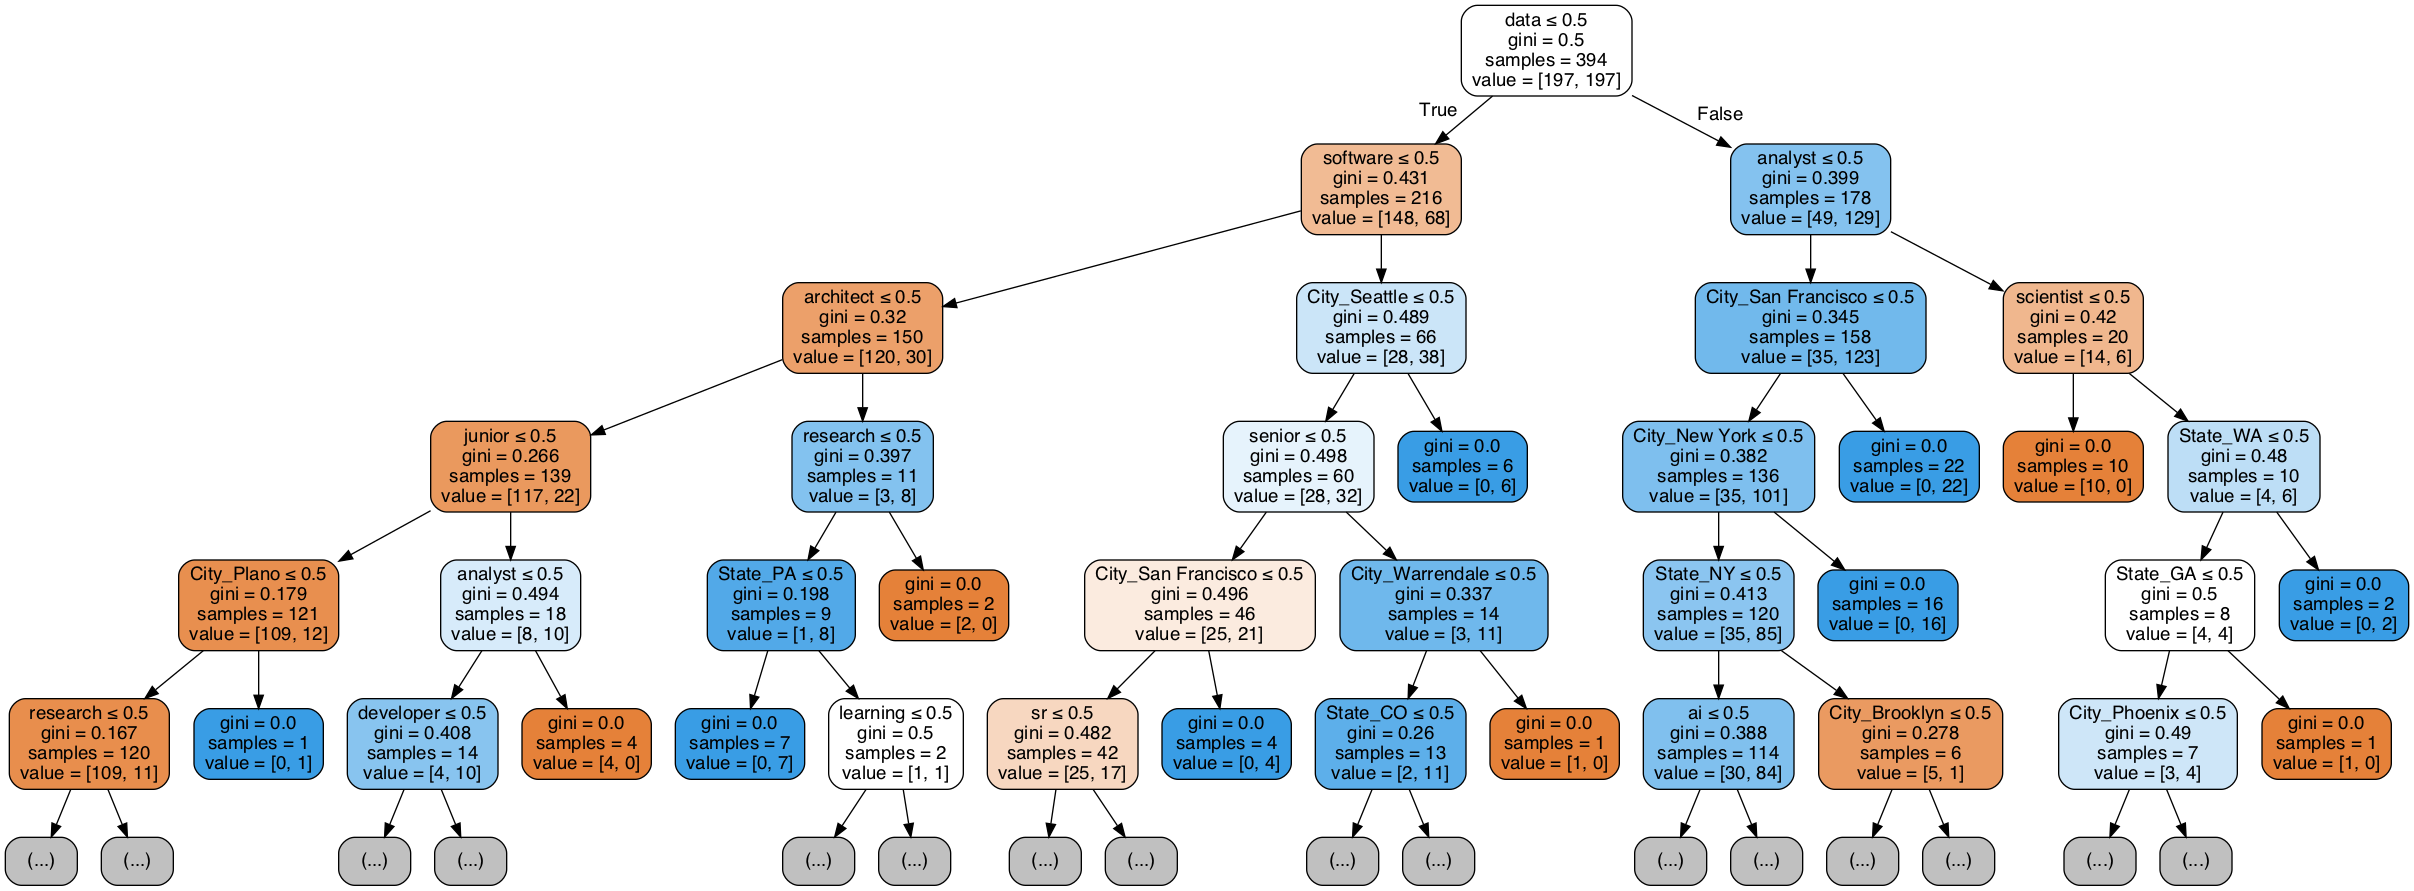

In [160]:
plot_dt(dtr_Binary, feature_names=XTR_Binary.columns)

**Running a Random Forest model rfc_Binary**

In [161]:
rfc_test_score_Binary, rfc_train_score_Binary, rfc_predictions_Binary, rfc_conf_matrix_Binary, rfc_class_report_Binary, rfc_Binary = madness_begging(model_RF, pred_matrix, df3.Binary_Salary)


Basic model chosen:
RandomForestClassifier()

Cross val score on train score:
[0.64912281 0.63157895 0.52631579 0.67857143 0.67857143 0.375
 0.32142857 0.35714286 0.625      0.55357143]
<built-in method mean of numpy.ndarray object at 0x12cadff30>
Test score:
0.7455621301775148

Bagging
{'max_features': 121, 'max_samples': 1.0}

Cross val score on train score:
[0.71929825 0.68421053 0.52631579 0.66071429 0.66071429 0.41071429
 0.30357143 0.33928571 0.625      0.625     ]
<built-in method mean of numpy.ndarray object at 0x12c328df0>

Train score:
0.9390862944162437

Test score:
0.757396449704142

Confusion Matrix
[[59 26]
 [15 69]]

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.69      0.74        85
           1       0.73      0.82      0.77        84

    accuracy                           0.76       169
   macro avg       0.76      0.76      0.76       169
weighted avg       0.76      0.76      0.76       169



**Running the KNeighborsClassifier out of the function**
- The decision to run the KNeighbors Classifier out of the function is that it would take way too much time

In [162]:
bagging = BaggingClassifier(base_estimator=model_K,
                            max_samples=1., 
                            max_features=1., 
                            n_estimators=100)

print("Bagging KNeighbors Classifier training score:\t", 
      cross_val_score(bagging, XTR_Binary, yTR_Binary,
                    cv=5).mean())

bagging.fit(XTR_Binary, yTR_Binary)
print("KNN bagging test score:\t", bagging.score(XTS_Binary, yTS_Binary))

Bagging KNeighbors Classifier training score:	 0.7359948068808829
KNN bagging test score:	 0.7633136094674556


In [163]:
Kn_predictions = bagging.predict(XTS_Binary)

In [164]:
kn_conf_matrix = confusion_matrix(yTS_Binary, Kn_predictions)

In [165]:
kn_conf_matrix

array([[64, 21],
       [19, 65]])

In [166]:
kn_class_report = classification_report(yTS_Binary, Kn_predictions)

In [167]:
print(kn_class_report)

              precision    recall  f1-score   support

           0       0.77      0.75      0.76        85
           1       0.76      0.77      0.76        84

    accuracy                           0.76       169
   macro avg       0.76      0.76      0.76       169
weighted avg       0.76      0.76      0.76       169



## Conclusion on the Binary 

The 3 best models on the Test Score are in order : 
- The Logistic Regression with the predictors got from the Count Vectorizer (So every word in the Job Title (0.78)
- The Logistic Regression in GridSearch with keywords chosen (0.77)
- K Neighbors Classifier in GridSearch (0.77)

The 3 best models on the Training score are in order:
- Desicion Tree in Bagging and GridSearch with keywords chosen  (0.96)
- Random Forest in Baggin and GridSearch with keywords chosen (0.93)
- The Logistic Regression with the predictors got from the Count Vectorizer (So every word in the Job Title (0.86)

Unfortunately the machine wouldn't allow me to try my best test model in test score in the ensamble Bagging. But from the score this function doesn't seem get the best score (The score are pretty close (from 0.74-0.76).
We definitely increased the precision and the recall from the beginning. This show also that sometimes not always a complicate deep method is able to get the best score. Definitely more data would probably gave us a better score. 
The first hypotesis is still valid. Location and Job title could definitively help us to predict the final salary. 
The deep function built didn't give us the results that we were hoping, but we could si clearly that the Desicion Tree and Random Forest produce a massive results in the trainig score so we could probably think that with more data their forecasting power could increase. Although we can also see that important features that came out don't give us a clear results. Their values is always very small and distributed along the features.
As mentioned before I couldn't run the K Neighbor Classifier in the function also for the luck of computational power of my machine.
From the coefficients of the Logistic Regression that I plot we could see how some of the location from the previous analysis remain (California, Seattle, NY) and we can addsome words as data, architect and engineering. Negative value for Analysis (which could make sense since the new data job required more a data science than just simple analysis.
We can conclude that all the models gave us a decent score moving the precision from 1/2 (baseline) to 3/4, but we can also conclude that my analysis has been not very efficient as I run many models with great expense of computational power and time.
But sometimes we need to try different things or we will have always a doubt.
We could increase our models scraping more data and especially better data: Description of the job, keeping the hour and month rate (and transformed them). 

## - Class Salary

**Choosing my predictors for all the others models:**
- X based on the Location : State, City, Key words

**Choosing my target:**
- The Class Salary

**Using the same dummy variables from previous fit**

In [168]:
XTR_Class, XTS_Class, yTR_Class, yTS_Class = train_test_split(df_dummy, df3.Class_Salary,stratify=df3.Class_Salary, test_size=0.3, random_state=1) 


**Running Logistic Regression model for Class Salary (Again)**

In [169]:
lr_test_score_Class, lr_train_score_Class, lr_predictions_Class, lr_conf_matrix_Class, lr_class_report_Class, lr_Class = madness_begging(model_L, pred_matrix, df3.Class_Salary)


Basic model chosen:
LogisticRegression()

Cross val score on train score:
[0.57894737 0.45614035 0.21052632 0.42857143 0.39285714 0.375
 0.125      0.28571429 0.42857143 0.35714286]
<built-in method mean of numpy.ndarray object at 0x12b7913a0>
Test score:
0.4911242603550296

Bagging
{'max_features': 101, 'max_samples': 0.9}

Cross val score on train score:
[0.59649123 0.45614035 0.21052632 0.42857143 0.41071429 0.375
 0.16071429 0.26785714 0.44642857 0.35714286]
<built-in method mean of numpy.ndarray object at 0x12b172490>

Train score:
0.6446700507614214

Test score:
0.4970414201183432

Confusion Matrix
[[26  8  6  2]
 [ 7 16 11  8]
 [ 1 10 16 17]
 [ 3  6  6 26]]

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.62      0.66        42
           1       0.40      0.38      0.39        42
           2       0.41      0.36      0.39        44
           3       0.49      0.63      0.55        41

    accuracy                    

In [170]:
lr_Class = lr_Class.best_estimator_.base_estimator_.fit(XTR_Class, yTR_Class)

In [171]:
#lr_Class.coef_

In [172]:
Coefficient_lr_Class_class_1 = pd.DataFrame(list(zip(XTS_Class.columns,lr_Class.coef_[1], np.abs(lr_Class.coef_[1]))), columns=['Var','Coef', 'Coef_abs']).sort_values(by='Coef_abs', ascending=False)


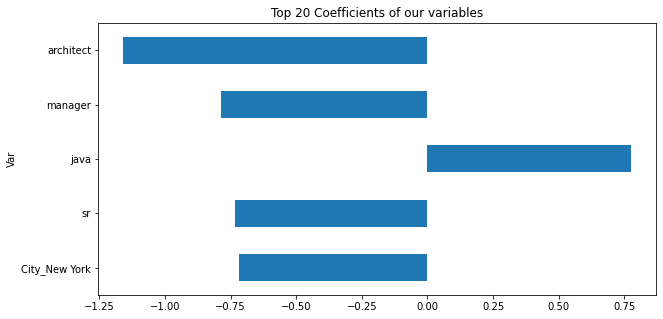

In [173]:
Coefficient_lr_Class_class_1.head().plot(kind='barh', x=0,y=1,figsize=(10,5),legend=False,title='Top 20 Coefficients of our variables', sort_columns=True)
plt.gca().invert_yaxis()

In [174]:
Coefficient_lr_Class_class_2 = pd.DataFrame(list(zip(XTS_Class.columns,lr_Class.coef_[2], np.abs(lr_Class.coef_[2]))), columns=['Var','Coef', 'Coef_abs']).sort_values(by='Coef_abs', ascending=False)


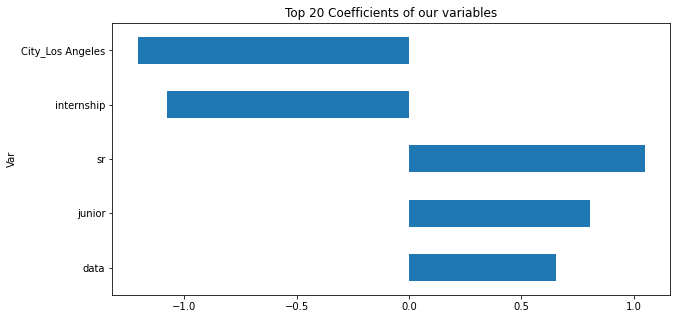

In [175]:
Coefficient_lr_Class_class_2.head().plot(kind='barh', x=0,y=1,figsize=(10,5),legend=False,title='Top 20 Coefficients of our variables', sort_columns=True)
plt.gca().invert_yaxis()

**Running Decision Tree Classifier model for Class Salary**

In [176]:
dtr_test_score_Class, dtr_train_score_Class, dtr_predictions_Class, dtr_conf_matrix_Class, dtr_class_report_Class, dtr_Class = madness_begging(model_DT, pred_matrix, df3.Class_Salary)


Basic model chosen:
DecisionTreeClassifier()

Cross val score on train score:
[0.40350877 0.45614035 0.21052632 0.5        0.5        0.26785714
 0.14285714 0.32142857 0.375      0.41071429]
<built-in method mean of numpy.ndarray object at 0x12c996cb0>
Test score:
0.47337278106508873

Bagging
{'max_features': 97, 'max_samples': 0.8}

Cross val score on train score:
[0.47368421 0.45614035 0.28070175 0.42857143 0.41071429 0.30357143
 0.16071429 0.26785714 0.41071429 0.35714286]
<built-in method mean of numpy.ndarray object at 0x12d3249e0>

Train score:
0.9086294416243654

Test score:
0.47928994082840237

Confusion Matrix
[[27  5 10  0]
 [10 17  8  7]
 [ 1 11 13 19]
 [ 3  8  6 24]]

Classification Report
              precision    recall  f1-score   support

           0       0.66      0.64      0.65        42
           1       0.41      0.40      0.41        42
           2       0.35      0.30      0.32        44
           3       0.48      0.59      0.53        41

    accuracy     

In [177]:
dtr_Class = dtr_Class.best_estimator_.base_estimator_.fit(XTR_Class, yTR_Class)

In [178]:
fi_dtr_Class = pd.DataFrame({
    'feature': XTR_Class.columns,
    'importance': dtr_Class.feature_importances_
})

fi_dtr_Class.sort_values('importance', ascending=False, inplace=True)
fi_dtr_Class.head()

,feature,importance
115,research,0.067956
110,architect,0.052985
102,engineer,0.049609
118,data,0.047244
105,analyst,0.040894


Max depth: None


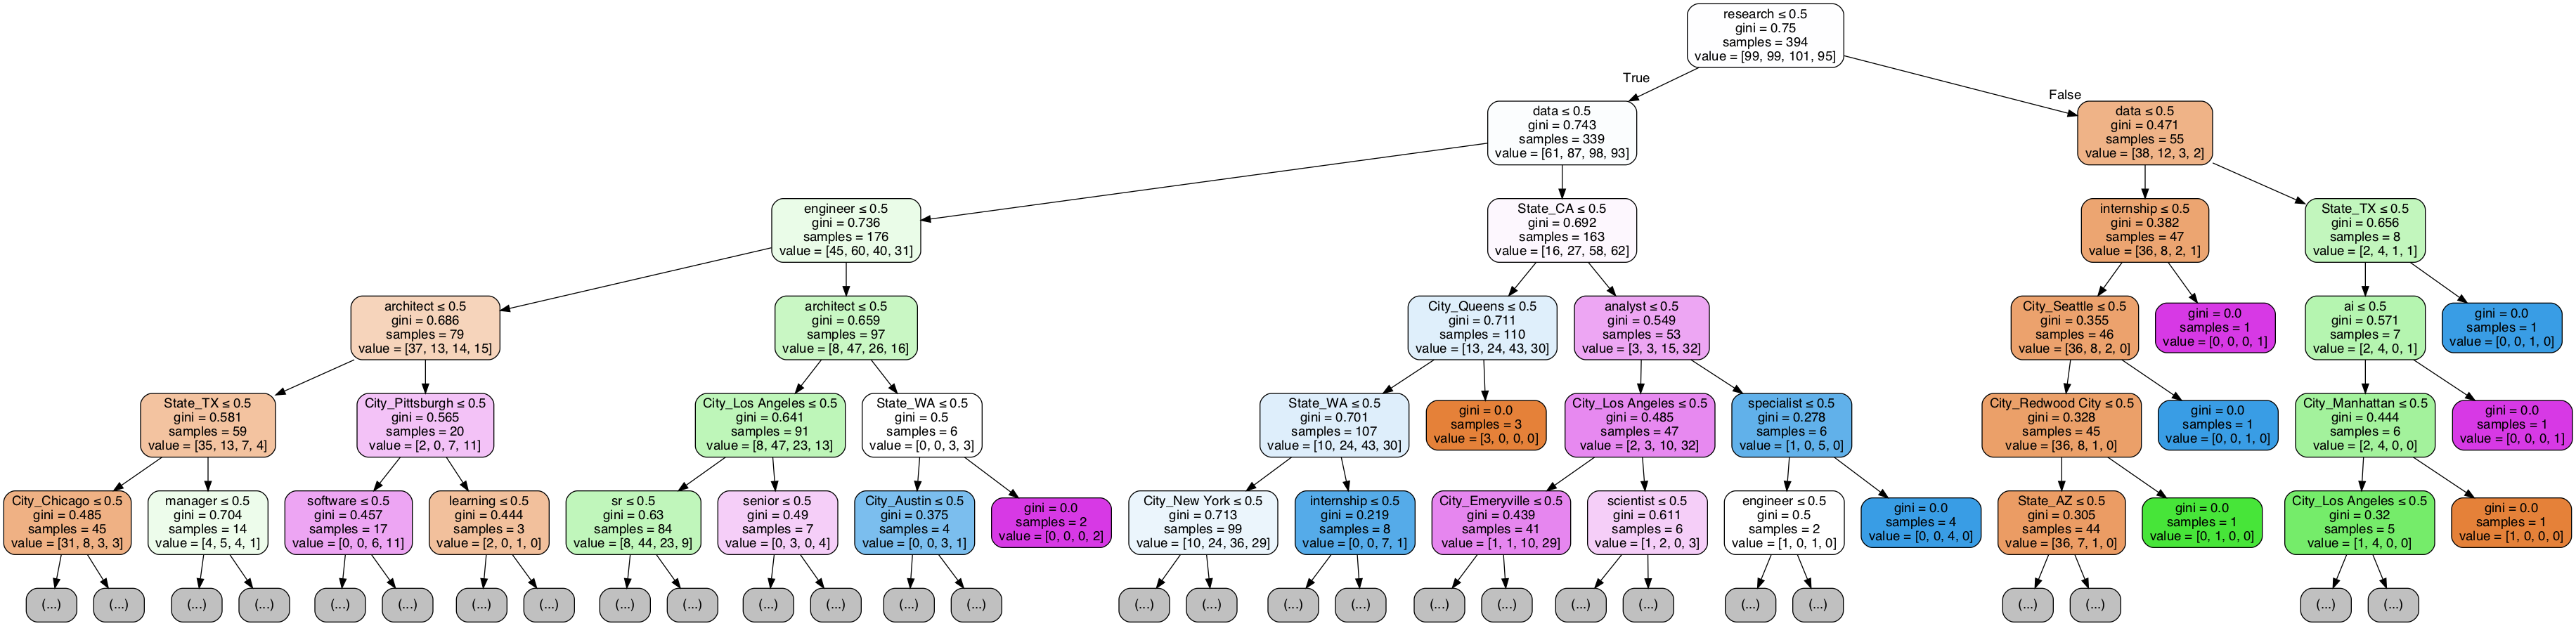

In [179]:
plot_dt(dtr_Class, feature_names=XTR_Class.columns)

**Running Random Forest model for Class Salary**

In [180]:
rfc_test_score_Class, rfc_train_score_Class, rfc_predictions_Class, rfc_conf_matrix_Class, rfc_class_report_Class, rfc_Class = madness_begging(model_RF, pred_matrix, df3.Class_Salary)


Basic model chosen:
RandomForestClassifier()

Cross val score on train score:
[0.50877193 0.45614035 0.19298246 0.375      0.41071429 0.375
 0.16071429 0.28571429 0.375      0.375     ]
<built-in method mean of numpy.ndarray object at 0x12c9c5260>
Test score:
0.48520710059171596

Bagging
{'max_features': 103, 'max_samples': 0.9}

Cross val score on train score:
[0.49122807 0.50877193 0.21052632 0.41071429 0.46428571 0.33928571
 0.16071429 0.28571429 0.42857143 0.35714286]
<built-in method mean of numpy.ndarray object at 0x12d094d50>

Train score:
0.8756345177664975

Test score:
0.4911242603550296

Confusion Matrix
[[26  7  9  0]
 [ 9 20  6  7]
 [ 1 12 12 19]
 [ 3  7  6 25]]

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.62      0.64        42
           1       0.43      0.48      0.45        42
           2       0.36      0.27      0.31        44
           3       0.49      0.61      0.54        41

    accuracy          

In [181]:
rfc_Class = rfc_Class.best_estimator_.base_estimator_.fit(XTR_Class, yTR_Class)

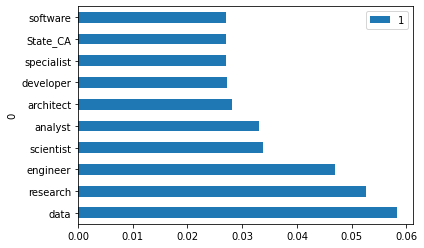

In [182]:
rfc_features = pd.DataFrame(list(zip(XTR_Class.columns,rfc_Class.feature_importances_))).sort_values(by=1,ascending=False)
rfc_features.head(10).plot(kind='barh',
    x=0,y=1)
plt.show()

In [183]:
rfc_features.head(10)

,0,1
118,data,0.058282
115,research,0.052624
102,engineer,0.046899
119,scientist,0.033819
105,analyst,0.033012
110,architect,0.028169
122,developer,0.027181
123,specialist,0.027028
1,State_CA,0.026979
103,software,0.026962


**Running KNeighbors Classifier model for Class Salary outside of the Function** (Same Reason as before)

In [184]:
bagging_Class = BaggingClassifier(base_estimator=model_K,
                            max_samples=1., 
                            max_features=1., 
                            n_estimators=100)

print("Bagging KNeighbors Classifier training score:\t", 
      cross_val_score(bagging, XTR_Class, yTR_Class,
                    cv=5).mean())

bagging.fit(XTR_Class, yTR_Class)
print("KNN bagging test score:\t", bagging.score(XTS_Class, yTS_Class))

Bagging KNeighbors Classifier training score:	 0.4999675430055177
KNN bagging test score:	 0.44970414201183434


## Conclusion on the Class Salary

Top 3 models on the Test score:
- Random Forest in Bagging and GridSearch with keywords chosen (0.50)
- Logistic Regression in GridSearch with DataFrame created from CountVectorizer and Location (0.5)
- Decision Tree in Bagging and GridSearch with keywords chosen (0.47)

Top 3 models on the Train score:
- Decision Tree in Bagging and GridSearch with keywords chosen (0.91)
- Random Forest in Bagging and GridSearch with keywords chosen (0.86)
- Logistic Regression in GridSearch with DataFrame created from CountVectorizer and Location (0.82)

The first difference that we see from the Binary is that the tops train score and test score presents the same models (only in differents order).
The second difference is that all models in general gained consistently increasing the predictors (words + locations).

The Logistic Regression in combo with CountVectorizer method is the only model present at the top of every score and in both analysis (Binary and Class). So it is definitely the best models we buit.
As we could expect it is more difficult to predict the 2 middle class (label 1 and 2). It is definitely easier predict correctly the very Low Salary class with a pretty high precision. 
In the coefficients for class 1 we see a negative value for Manager, Sr and Achitect (that was in our higher coefficients also in our Binary model). The Locations loose a lot of power. Most of them don't compare in our top predictors. It is easily explained from the fact that the model with just Location was probably only sufficient but not good for the multiclass. They don't bring a good enough provision for Multiclass.

Speaking about Decision Tree and Random Forest, as expected, they have again a massive score in the training score, but this time they kept a good score in the test. 
As in the Binary if we look at the important features we see very low value. In fact the plot is large and difficult to understand. That what happen when you choose to let the Decision Tree grow free without a set depth.
We definitely notice some similarities between coefficient in Logistic Regression, important features in Desicion Tree and Random Forest.
Architect, Data, Research are in both. It is a confirmation that the models are coherent between them. In the Decision Tree and Random Forest we can know only the importance in the decisions, but combining them with the coefficients of the Logistic Regression we can also see which direction they would take.
0.5 is not a great score but we are still increasing our chaces to predict right from the 1 on 4 (baseline) to 1 on 2. 

#### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. 


- Use cross-validation to evaluate your models. 
- Evaluate the accuracy, AUC, precision and recall of the models. 
- Plot the ROC and precision-recall curves for at least one of your models.

In [185]:
from sklearn.preprocessing import label_binarize
from sklearn import metrics
import scikitplot as skplt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns

In [186]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

To predict incorrectly the salary, in the way that the candidate would expect a lower salary, we need to increase the threshold so we could decrease the number of true positive and false negative.

**Prediction with normal threshold at 0.5**

I am going to solve this problem with one of my best model which is the Logistic Regression with GridSearch

In [187]:
Y_pp = pd.DataFrame(g_log.predict_proba(XTS_Binary), columns=[
                    'class_Low', 'class_High'])


In [188]:
Y_pp['pred_class_thresh'] = [
    1 if x >= 0.50 else 0 for x in Y_pp.class_High.values]
Y_pp.head()

,class_Low,class_High,pred_class_thresh
0,0.992283,0.007717,0
1,0.673849,0.326151,0
2,0.865316,0.134684,0
3,0.288868,0.711132,1
4,0.973694,0.026306,0


In [189]:
conmat = np.array(confusion_matrix(
    yTS_Binary, Y_pp.pred_class_thresh, labels=[0, 1]))

confusion = pd.DataFrame(conmat, index=['Low', 'High'],
                         columns=['predicted_Low', 'predicted_High'])
confusion

,predicted_Low,predicted_High
Low,64,21
High,17,67


In [190]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

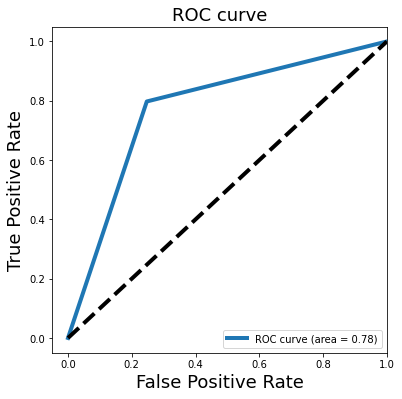

In [191]:
fpr, tpr, threshold = roc_curve(yTS_Binary, Y_pp.pred_class_thresh)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

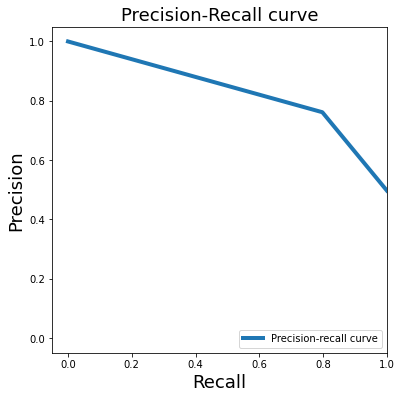

In [192]:
# For class 1, find the area under the curve
precision, recall, threshold = precision_recall_curve(yTS_Binary, Y_pp.pred_class_thresh)


# Plot of a precision-recall curve for class 1 (benign)
plt.figure(figsize=[6, 6])
plt.plot(recall, precision, label='Precision-recall curve', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

Increasing the Threshold from 0.5 to 0.7

In [193]:
Y_thre = Y_pp.copy()

In [194]:
Y_thre['pred_class_thresh'] = [
    1 if x >= 0.7 else 0 for x in Y_pp.class_High.values]
Y_thre.head()

,class_Low,class_High,pred_class_thresh
0,0.992283,0.007717,0
1,0.673849,0.326151,0
2,0.865316,0.134684,0
3,0.288868,0.711132,1
4,0.973694,0.026306,0


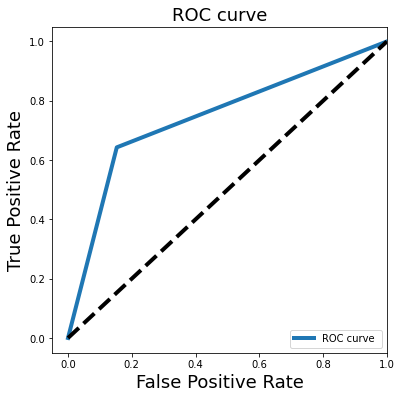

In [195]:
fpr_thre, tpr_thre, threshold_thre = roc_curve(yTS_Binary, Y_thre.pred_class_thresh)
roc_auc_thre = auc(fpr_thre, tpr_thre)

# Plot of a ROC curve for class 1
plt.figure(figsize=[6, 6])
plt.plot(fpr_thre, tpr_thre, label='ROC curve ' % roc_auc_thre, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

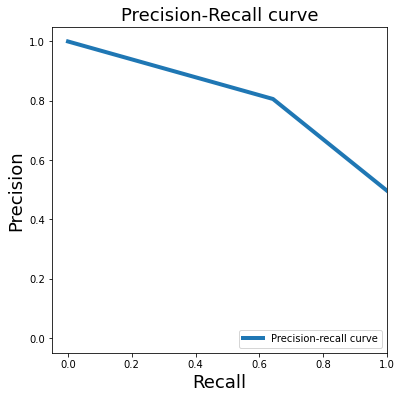

In [196]:
# For class 1, find the area under the curve
precision_thre, recall_thre, threshold_thre = precision_recall_curve(yTS_Binary, Y_thre.pred_class_thresh)


# Plot of a precision-recall curve for class 1 (benign)
plt.figure(figsize=[6, 6])
plt.plot(recall_thre, precision_thre, label='Precision-recall curve', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

We can see how the True Positive value decrease from 0.8 to 0.6 in our second graph if we increase the threshold to 0.7. We used the Logistic Regression with GridSearch that was our second best model for the Binary. Of course we will have a worst classifier, but this is our purpose.

**Plottin a prettier ROC/AUC curve for Random forest classifier for my class analysis**

Train set

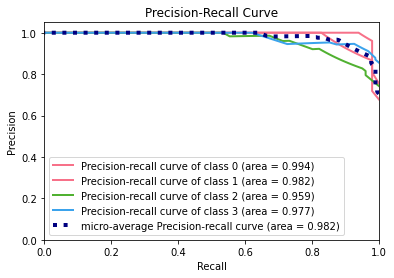

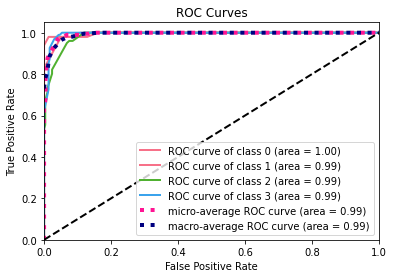

In [197]:
probabilities_train = rfc_Class.predict_proba(XTR_Class)
probabilities_test = rfc_Class.predict_proba(XTS_Class)
skplt.metrics.plot_precision_recall(yTR_Class, probabilities_train, cmap=cmap)
plt.show()
skplt.metrics.plot_roc(yTR_Class, probabilities_train, cmap=cmap)
plt.show()

Test set

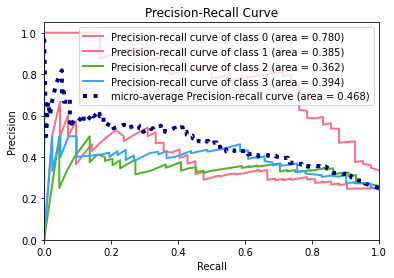

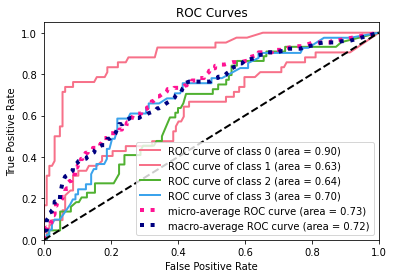

In [198]:

skplt.metrics.plot_precision_recall(yTS_Class, probabilities_test, cmap=cmap)
plt.show()
skplt.metrics.plot_roc(yTS_Class, probabilities_test, cmap=cmap)
plt.show()